# Run hacked AlphaFold2 on the MPNN designed binders

### Imports

In [1]:
%load_ext lab_black
# Python standard library
from glob import glob
import os
import socket
import sys

# 3rd party library imports
import dask
import matplotlib.pyplot as plt
import pandas as pd
import pyrosetta
import numpy as np
import scipy
import seaborn as sns
from tqdm.auto import tqdm  # jupyter compatible progress bar

tqdm.pandas()  # link tqdm to pandas
# Notebook magic
# save plots in the notebook
%matplotlib inline
# reloads modules automatically before executing cells
%load_ext autoreload
%autoreload 2
print(f"running in directory: {os.getcwd()}")  # where are we?
print(f"running on node: {socket.gethostname()}")  # what node are we on?

running in directory: /mnt/projects/crispy_shifty/projects/crispy_crispies
running on node: dig109


### Set working directory to the root of the crispy_shifty repo
Note: We want to use perlmutter

In [2]:
os.chdir("/global/cfs/cdirs/m4129/projects/crispy_shifty")

### Fix the paths
Necessary because we are on perlmutter

In [3]:
from crispy_shifty.utils.io import fix_path_prefixes

pairs = os.path.join(
    os.getcwd(), "projects/crispy_crispies/06_mpnn_again/mpnn_binders.pair"
)
new_pairs = fix_path_prefixes(
    find="/mnt",
    replace="/global/cfs/cdirs/m4129",
    file=pairs,
    overwrite=True,
)

/global/cfs/cdirs/m4129/projects/crispy_shifty/envs/crispy/lib/python3.8/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


### Run AF2 on the MPNN designed binders

In [ ]:
from crispy_shifty.utils.io import gen_array_tasks

simulation_name = "07_fold_again"
design_list_file = os.path.join(
    os.getcwd(),
    "projects/crispy_crispies/06_mpnn_again/mpnn_binders.pair",
)
output_path = os.path.join(f"/pscratch/sd/p/pleung/{simulation_name}")

options = " ".join(
    [
        "out:level 200",
    ]
)
extra_kwargs = {"models": "1"}

gen_array_tasks(
    distribute_func="projects.crispy_crispies.deployables.fold_binder",
    design_list_file=design_list_file,
    output_path=output_path,
    perlmutter_mode=True,
    nstruct=1,
    nstruct_per_task=1,
    options=options,
    extra_kwargs=extra_kwargs,
    simulation_name=simulation_name,
    time="24:00",
)

### Set working directory to the root of the crispy_shifty repo
Note: We rsync the perlmutter results, now back on the digs

In [2]:
os.chdir("/projects/crispy_shifty")

### Collect scorefiles of the folded bound states and concatenate

In [3]:
sys.path.insert(0, "/projects/crispy_shifty")
from crispy_shifty.utils.io import collect_score_file

simulation_name = "07_fold_again"
output_path = os.path.join(os.getcwd(), f"projects/crispy_crispies/{simulation_name}")

if not os.path.exists(os.path.join(output_path, "scores.json")):
    collect_score_file(output_path, "scores")

### Load resulting concatenated scorefile

In [4]:
sys.path.insert(0, "/projects/crispy_shifty")
from crispy_shifty.utils.io import parse_scorefile_linear

output_path = os.path.join(os.getcwd(), f"projects/crispy_crispies/{simulation_name}")

if not os.path.exists(os.path.join(output_path, "scores.csv")):
    scores_df = parse_scorefile_linear(os.path.join(output_path, "scores.json"))

  0%|          | 0/870075 [00:00<?, ?it/s]

### Dump scores_df as a CSV and then reload, for performance reasons

In [5]:
if not os.path.exists(os.path.join(output_path, "scores.csv")):
    scores_df.to_csv(os.path.join(output_path, "scores.csv"))

scores_df = pd.read_csv(os.path.join(output_path, "scores.csv"), index_col="Unnamed: 0")

### Setup for plotting

In [6]:
sns.set(
    context="talk",
    font_scale=1,  # make the font larger; default is pretty small
    style="ticks",  # make the background white with black lines
    palette="colorblind",  # a color palette that is colorblind friendly!
)

### Data exploration
Gonna remove the Rosetta sfxn scoreterms for now

In [7]:
rosetta = scores_df[scores_df["designed_by"] == "rosetta"]
mpnn = scores_df[scores_df["designed_by"] == "mpnn"].sample(1000, random_state=0)
sample_df = pd.concat([rosetta, mpnn])

In [8]:
from crispy_shifty.protocols.design import beta_nov16_terms

sample_df = sample_df[
    [term for term in sample_df.columns if term not in beta_nov16_terms]
]
print(len(sample_df))
print(list(sample_df.columns))

17589
['bb_clash', 'bb_clash_delta', 'best_average_DAN_plddts', 'best_average_plddts', 'best_model', 'best_ptm', 'best_rmsd_to_input', 'buns_parent', 'chA_seq', 'cms', 'cms_AcB', 'cms_AnAc', 'cms_AnAcB', 'cms_AnB', 'count_apolar', 'ddg', 'designed_by', 'docked_helix', 'dssp', 'elapsed_time', 'exposed_hydrophobics_parent', 'geometry_parent', 'holes_all_parent', 'holes_core_parent', 'insertion_dG', 'kept_end', 'kept_start', 'loop_dist', 'loop_sc', 'looped_length', 'mean_pae', 'mean_pae_interaction', 'mean_pae_interaction_AB', 'mean_pae_interaction_BA', 'mean_pae_intra_chain', 'mean_pae_intra_chain_A', 'mean_pae_intra_chain_B', 'mean_plddt', 'mismatch_probability_parent', 'model', 'mpnn_design_area', 'mpnn_temperature', 'new_loop_str', 'pTMscore', 'packstat_parent', 'parent', 'parent_length', 'path_in', 'pdb', 'pivot_helix', 'pre_break_helix', 'prefix', 'recycles', 'rmsd_to_reference', 'sap_parent', 'sc_AcB', 'sc_AnAc', 'sc_AnAcB', 'sc_AnB', 'sc_all_parent', 'scaffold_type', 'score', 'sco

In [9]:
from crispy_shifty.utils.plotting import histplot_df, pairplot_df

### Plot before and after interface design AF2 metrics

4it [00:00, 19.49it/s]


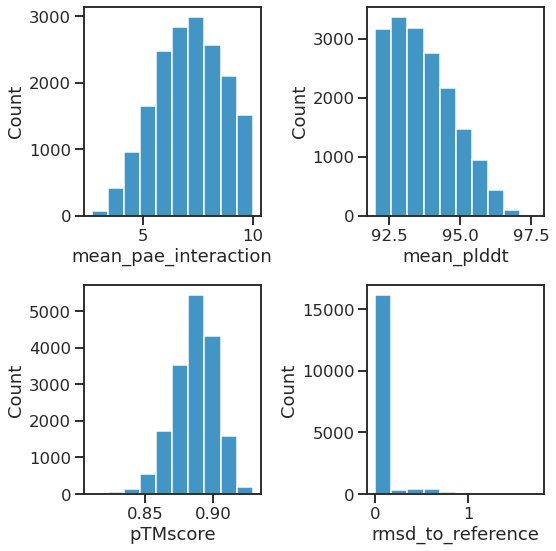

In [12]:
cols = [
    "mean_pae_interaction",
    "mean_plddt",
    "pTMscore",
    "rmsd_to_reference",
]
the_fig = histplot_df(
    df=sample_df,
    cols=cols,
    bins=10,
)
plt.savefig(os.path.join(output_path, "old_vs_new_af2_scores.png"))

### Plot interface metrics

6it [00:00, 15.59it/s]


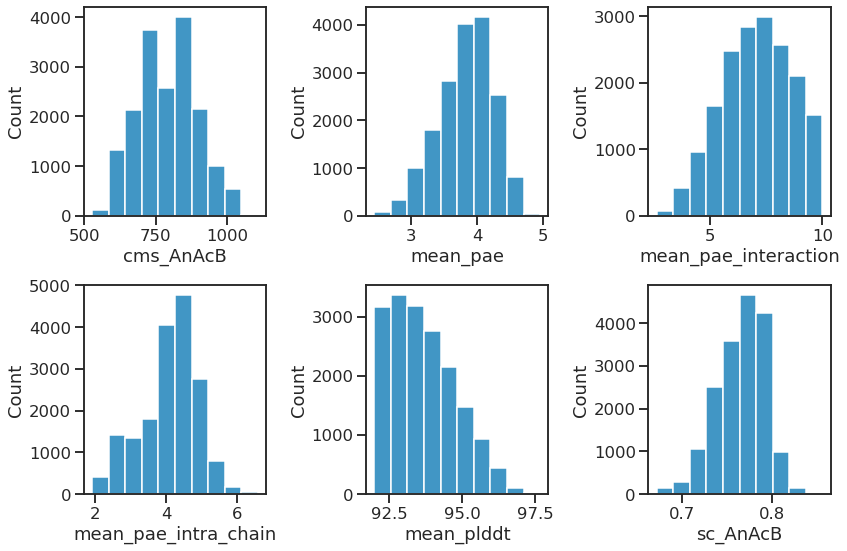

In [13]:
cols = [
    "cms_AnAcB",
    "mean_pae",
    "mean_pae_interaction",
    "mean_pae_intra_chain",
    "mean_plddt",
    "sc_AnAcB",
]
the_fig = histplot_df(
    df=sample_df,
    cols=cols,
    bins=10,
)
plt.savefig(os.path.join(output_path, "interface_scores.png"))

<Figure size 1728x1728 with 0 Axes>

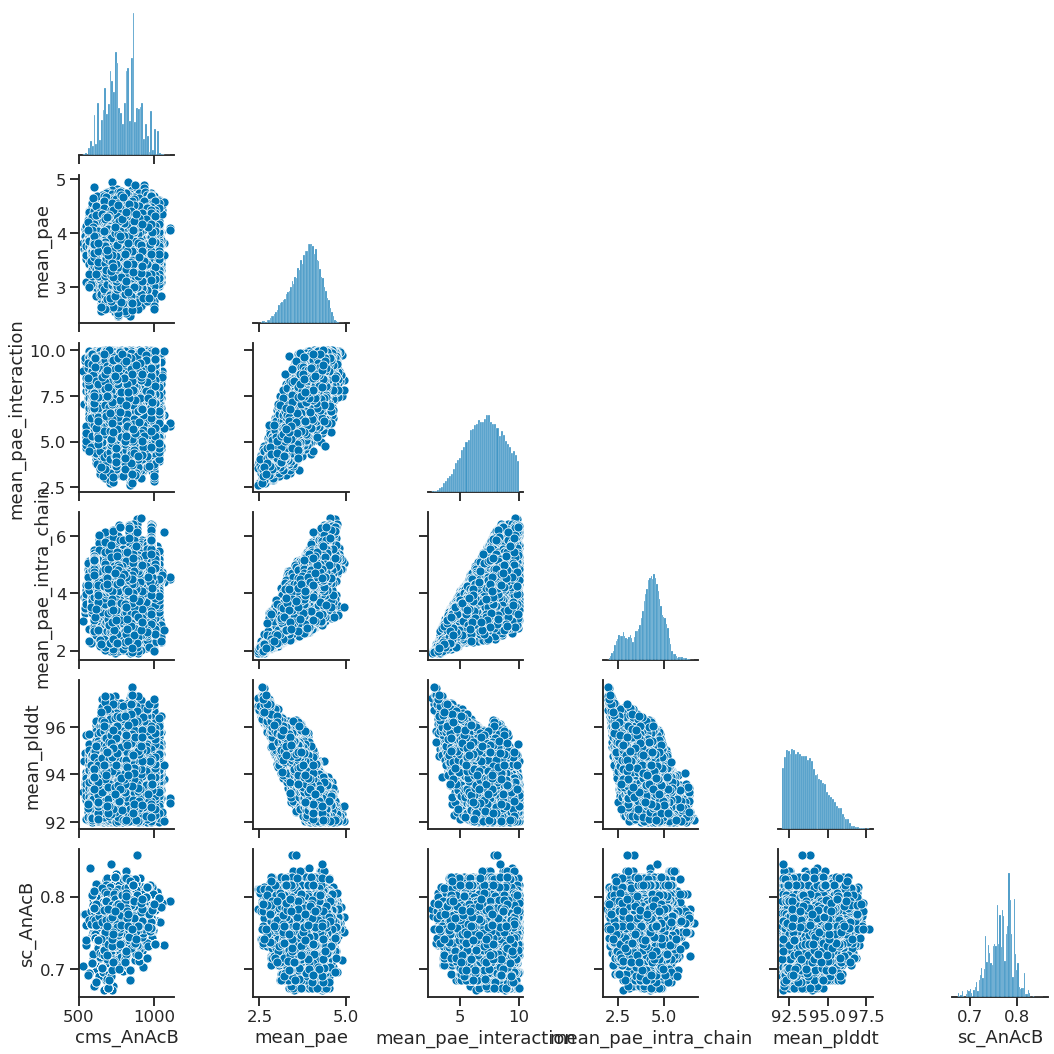

In [14]:
the_fig = pairplot_df(
    df=sample_df,
    cols=cols,
)
plt.savefig(os.path.join(output_path, "interface_scores_paired.png"))

In [15]:
scores_df.groupby("target_name").count()

,bb_clash,bb_clash_delta,best_average_DAN_plddts,best_average_plddts,best_model,best_ptm,best_rmsd_to_input,buns_parent,chA_seq,cms,...,target_seq,threaded_seq,time,tol,topo,total_length,total_score,trimmed_length,type,yhh_planarity
target_name,,,,,,,,,,,,,,,,,,,,,
APOE,208731,208731,208731,208731,208731,208731,208731,208731,208731,208731,...,208731,208731,208731,208731,208731,208731,208731,208731,208731,208731
GIP,28443,28443,28443,28443,28443,28443,28443,28443,28443,28443,...,28443,28443,28443,28443,28443,28443,28443,28443,28443,28443
GLP1,5144,5144,5144,5144,5144,5144,5144,5144,5144,5144,...,5144,5144,5144,5144,5144,5144,5144,5144,5144,5144
GLP2,114978,114978,114978,114978,114978,114978,114978,114978,114978,114978,...,114978,114978,114978,114978,114978,114978,114978,114978,114978,114978
Glicentin,4073,4073,4073,4073,4073,4073,4073,4073,4073,4073,...,4073,4073,4073,4073,4073,4073,4073,4073,4073,4073
Glucagon,2193,2193,2193,2193,2193,2193,2193,2193,2193,2193,...,2193,2193,2193,2193,2193,2193,2193,2193,2193,2193
NPY_9-35,140183,140183,140183,140183,140183,140183,140183,140183,140183,140183,...,140183,140183,140183,140183,140183,140183,140183,140183,140183,140183
PTH,53126,53126,53126,53126,53126,53126,53126,53126,53126,53126,...,53126,53126,53126,53126,53126,53126,53126,53126,53126,53126
Secretin,313204,313204,313204,313204,313204,313204,313204,313204,313204,313204,...,313204,313204,313204,313204,313204,313204,313204,313204,313204,313204


### Filter the whole df

In [17]:
filtered = scores_df
len(filtered)

870075

### Save a list of outputs
Sort by length  

In [18]:
simulation_name = "07_fold_again"
output_path = os.path.join(os.getcwd(), f"projects/crispy_crispies/{simulation_name}")
filtered = filtered.sort_values("total_length")
with open(os.path.join(output_path, "folded_binders.list"), "w") as f:
    for path in tqdm(filtered.index):
        print(path, file=f)

  0%|          | 0/870075 [00:00<?, ?it/s]

### Fix the paths
Necessary because we transferred from perlmutter

In [19]:
from crispy_shifty.utils.io import fix_path_prefixes

_ = fix_path_prefixes(
    find="/pscratch/sd/p/pleung",
    replace="/mnt/projects/crispy_shifty/projects/crispy_crispies",
    file=os.path.join(
        os.getcwd(),
        "projects/crispy_crispies/07_fold_again/folded_binders.list",
    ),
    overwrite=True,
)

### Prototyping blocks